#### **Convolutional Neural Network Model**

#### **Load the dataset**

In [ ]:
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle/

!kaggle datasets download -d msambare/fer2013

!unzip /content/fer2013.zip -d /content/

from google.colab import drive
drive.mount('/content/drive')


Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  
  inflating: /content/train/sad/Training_65508578.jpg  

#### **Libraries**

In [ ]:
import os
import cv2
import json
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
plt.style.use('default')

from tensorflow.keras.layers import *
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50V2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


#### **List all directories and files in the current directory**

In [ ]:
root_dir = '/content/'
folders = os.listdir(root_dir)

print("Folders and files in the root directory:")
print(folders)


Folders and files in the root directory:
['.config', 'sample_data']


#### **Defining the paths to your train and test directories**

In [ ]:
train_data_path = '/content/train/'
test_data_path = '/content/test/'

# List folders in the train and test directories
train_folders = os.listdir(train_data_path )
test_folders = os.listdir(test_data_path)

print("Folders in the train directory:")
print(train_folders)

print("\nFolders in the test directory:")
print(test_folders)

Folders in the train directory:
['neutral', 'sad', 'disgust', 'angry', 'happy', 'surprise', 'fear']

Folders in the test directory:
['neutral', 'sad', 'disgust', 'angry', 'happy', 'surprise', 'fear']


#### **Data Preprocessing and Augmentation for Emotion Detection**





In [ ]:
# Set the image size and batch size
img_shape = 48
batch_size = 64

# ImageDataGenerator for training (with data augmentation) and validation (without augmentation)
train_preprocessor = ImageDataGenerator(
    rescale=1 / 255.,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Reserve 20% of the training data for validation
)

test_preprocessor = ImageDataGenerator(
    rescale=1 / 255.
)

# Load the training data (80% of the original training data)
train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training'  # Only use the training subset (80% of data)
)

# Load the validation data (20% of the original training data)
validation_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size,
    subset='validation'  # Only use the validation subset (20% of data)
)

# Load the test data (separate test set)
test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


#### **Model definition**

In [ ]:
def create_cnn_model():
    model = Sequential()

    # Adjust the input shape to (48, 48, 3)
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.25))

    # Flatten the output of the convolutional layers
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Output layer for 7 classes
    model.add(Dense(7, activation='softmax'))

    return model


#### **Compile the model**

In [ ]:
cnn_model = create_cnn_model()
cnn_model.summary()
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 46, 46, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 46, 46, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 46, 46, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 46, 46, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 21, 21, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 21, 21, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 21, 21, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 9, 9, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 9, 9, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 9, 9, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 9, 9, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 7,664,775 (29.24 MB)

 Trainable params: 7,660,359 (29.22 MB)

 Non-trainable params: 4,416 (17.25 KB)

#### **Training CNN Model**

In [ ]:
CNN = cnn_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=200,
    batch_size=batch_size,
    callbacks=callbacks
)


Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.2099 - loss: 2.5472
Epoch 1: val_loss improved from inf to 1.98984, saving model to best_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 65s 146ms/step - accuracy: 0.2101 - loss: 2.5455 - val_accuracy: 0.2620 - val_loss: 1.9898 - learning_rate: 0.0010
Epoch 2/200
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3126 - loss: 1.8240
Epoch 2: val_loss improved from 1.98984 to 1.65379, saving model to best_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 43s 116ms/step - accuracy: 0.3127 - loss: 1.8237 - val_accuracy: 0.3402 - val_loss: 1.6538 - learning_rate: 0.0010
Epoch 3/200
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3829 - loss: 1.6043
Epoch 3: val_loss improved from 1.65379 to 1.55743, saving model to best_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 83s 120ms/step - accuracy: 0.3830 - loss: 1.6042 - val_accuracy: 0.3860 - val_loss: 1.5574 - learning_rate: 0.0010
Epoch 4/200
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy

#### **Plotting Training and Validation Accuracy and Loss Over Epochs**

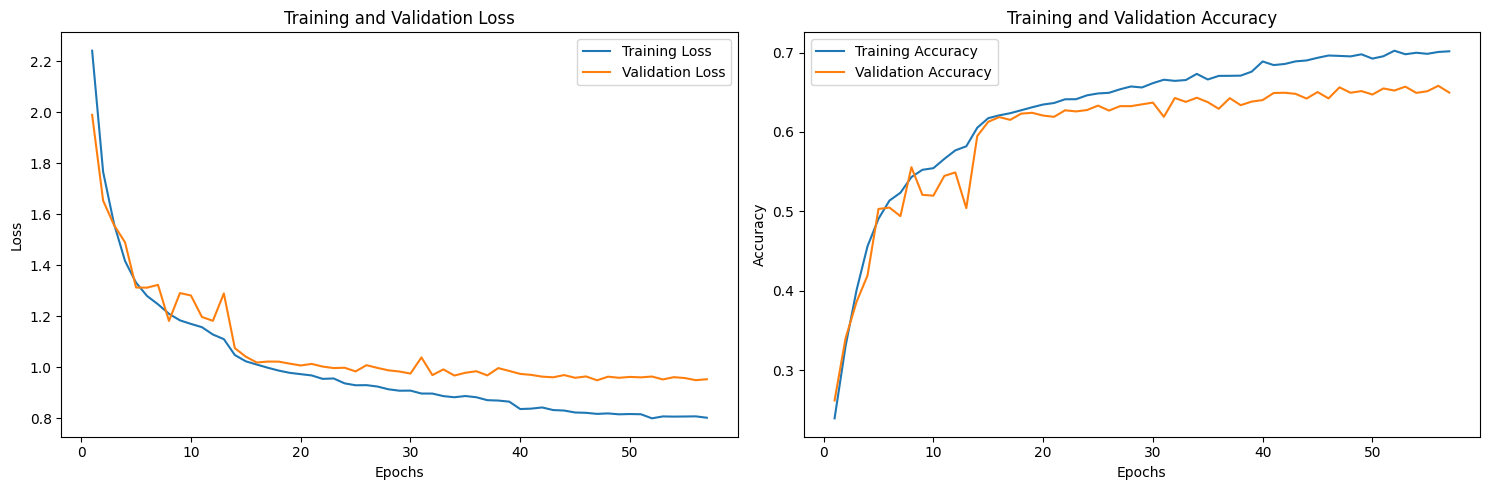

In [ ]:
history = CNN.history
# Get the values for accuracy, loss, and validation metrics
epochs = range(1, len(history['accuracy']) + 1)
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

# Plot the training and validation accuracy and loss
plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label="Training Accuracy")
plt.plot(epochs, val_accuracy, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

#### **Best Epoch and Accuracy**

In [ ]:
best_epoch = CNN.history['val_loss'].index(min(CNN.history['val_loss'])) + 1

best_train_accuracy = CNN.history['accuracy'][best_epoch - 1]
best_val_accuracy = CNN.history['val_accuracy'][best_epoch - 1]

print(f"The best epoch based on validation loss is: {best_epoch}")
print(f"Training Accuracy at best epoch: {best_train_accuracy:.4f}")
print(f"Validation Accuracy at best epoch: {best_val_accuracy:.4f}")


The best epoch based on validation loss is: 47
Training Accuracy at best epoch: 0.6958
Validation Accuracy at best epoch: 0.6562


#### **Loading the Best Model and Evaluating Performance on Test Data**

In [ ]:
best_model = load_model('/content/drive/MyDrive/Emotion_Detection/CNN_Model/CNN_Output/CNN_model.keras')

# Evaluate the best model on test data
test_loss, test_accuracy = best_model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.6302 - loss: 1.0049
Test Accuracy: 0.6662
Test Loss: 0.9249


#### **Comparison of Train, Validation, and Test Accuracy at Best Epoch**

In [ ]:
# Step 1: Identify the best epoch based on validation loss
best_epoch = CNN.history['val_loss'].index(min(CNN.history['val_loss'])) + 1

# Step 2: Retrieve the training and validation accuracy for that best epoch
best_train_accuracy = CNN.history['accuracy'][best_epoch - 1]
best_val_accuracy = CNN.history['val_accuracy'][best_epoch - 1]

# Step 3: Load the best model saved by ModelCheckpoint
best_model = load_model('best_model.keras')

# Step 4: Evaluate the best model on test data
test_loss, test_accuracy = best_model.evaluate(test_data)

# Step 5: Print and compare all accuracies
print(f"Best Epoch: {best_epoch}")
print(f"Training Accuracy at best epoch: {best_train_accuracy:.4f}")
print(f"Validation Accuracy at best epoch: {best_val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6302 - loss: 1.0049
Best Epoch: 47
Training Accuracy at best epoch: 0.6958
Validation Accuracy at best epoch: 0.6562
Test Accuracy: 0.6662


#### **Confusion Matrix**

In [ ]:
true_labels = test_data.classes

# Get the predicted labels from the model
pred_probabilities = best_model.predict(test_data)
pred_labels = np.argmax(pred_probabilities, axis=1)

# Get the class labels from the test_data generator
class_labels = list(test_data.class_indices.keys())

# Create the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

cm_text = [[str(cell) for cell in row] for row in cm]

# Plot the confusion matrix using Plotly
fig = go.Figure(data=go.Heatmap(
        z=cm,
        x=class_labels,
        y=class_labels,
        colorscale='Blues',
        hoverongaps=False,
        text=cm_text,
        texttemplate="%{text}"
    ))


fig.update_layout(
    title="Confusion Matrix (CNN Model)",
    xaxis_title="Predicted Labels",
    yaxis_title="True Labels",
)

# Show the plot
fig.show()


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step


#### **Saving and Downloading the Trained CNN Model**

In [ ]:
# Save the trained model to Google Drive
cnn_model.save('/content/drive/MyDrive/Emotion_Detection/CNN_Model/CNN_Output/CNN_model.keras')

# Download the saved model from Google Drive
from google.colab import files
files.download('/content/drive/MyDrive/Emotion_Detection/CNN_Model/CNN_Output/CNN_model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### **Saving the Accuracies**

In [ ]:
# Step 1: Identify the best epoch based on validation loss
best_epoch = CNN.history['val_loss'].index(min(CNN.history['val_loss'])) + 1

# Step 2: Retrieve key metrics (accuracy and loss) with rounding
best_train_accuracy = round(CNN.history['accuracy'][best_epoch - 1], 2)
best_val_accuracy = round(CNN.history['val_accuracy'][best_epoch - 1], 2)
best_train_loss = round(CNN.history['loss'][best_epoch - 1], 2)
best_val_loss = round(CNN.history['val_loss'][best_epoch - 1], 2)

# Step 3: Load the best saved model (properly named as CNN_model)
CNN_model_path = '/content/drive/MyDrive/Emotion_Detection/CNN_Model/CNN_Output/CNN_model.keras'
CNN_model = load_model(CNN_model_path)

# Step 4: Evaluate the best model on test data
test_loss, test_accuracy = CNN_model.evaluate(test_data)
test_loss = round(test_loss, 2)
test_accuracy = round(test_accuracy, 2)

# Step 5: Collect all the metrics in a DataFrame with updated CNN-related names
metrics_df = pd.DataFrame({
    'Metric': ['CNN Best Epoch', 'CNN Train Accuracy', 'CNN Validation Accuracy', 'CNN Train Loss', 'CNN Validation Loss', 'CNN Test Accuracy', 'CNN Test Loss'],
    'Value': [best_epoch, best_train_accuracy, best_val_accuracy, best_train_loss, best_val_loss, test_accuracy, test_loss]
})

# Step 6: Save the DataFrame and model to Google Drive or any local directory
save_path = '/content/drive/MyDrive/Emotion_Detection/CNN_Model/CNN_Output'
os.makedirs(save_path, exist_ok=True)

# Save the metrics as a CSV file
metrics_save_path = os.path.join(save_path, 'cnn_model_metrics.csv')
metrics_df.to_csv(metrics_save_path, index=False)

# Save the best model (properly named as CNN_model)
model_save_path = os.path.join(save_path, 'CNN_model.keras')
CNN_model.save(model_save_path)

print(f"Best model and metrics successfully saved to {save_path}")

# Display the DataFrame with metrics
metrics_df


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6302 - loss: 1.0049
Best model and metrics successfully saved to /content/drive/MyDrive/Emotion_Detection/CNN_Model/CNN_Output


,Metric,Value
0,CNN Best Epoch,47.00
1,CNN Train Accuracy,0.70
2,CNN Validation Accuracy,0.66
3,CNN Train Loss,0.82
4,CNN Validation Loss,0.95
5,CNN Test Accuracy,0.67
6,CNN Test Loss,0.92


#### **Prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


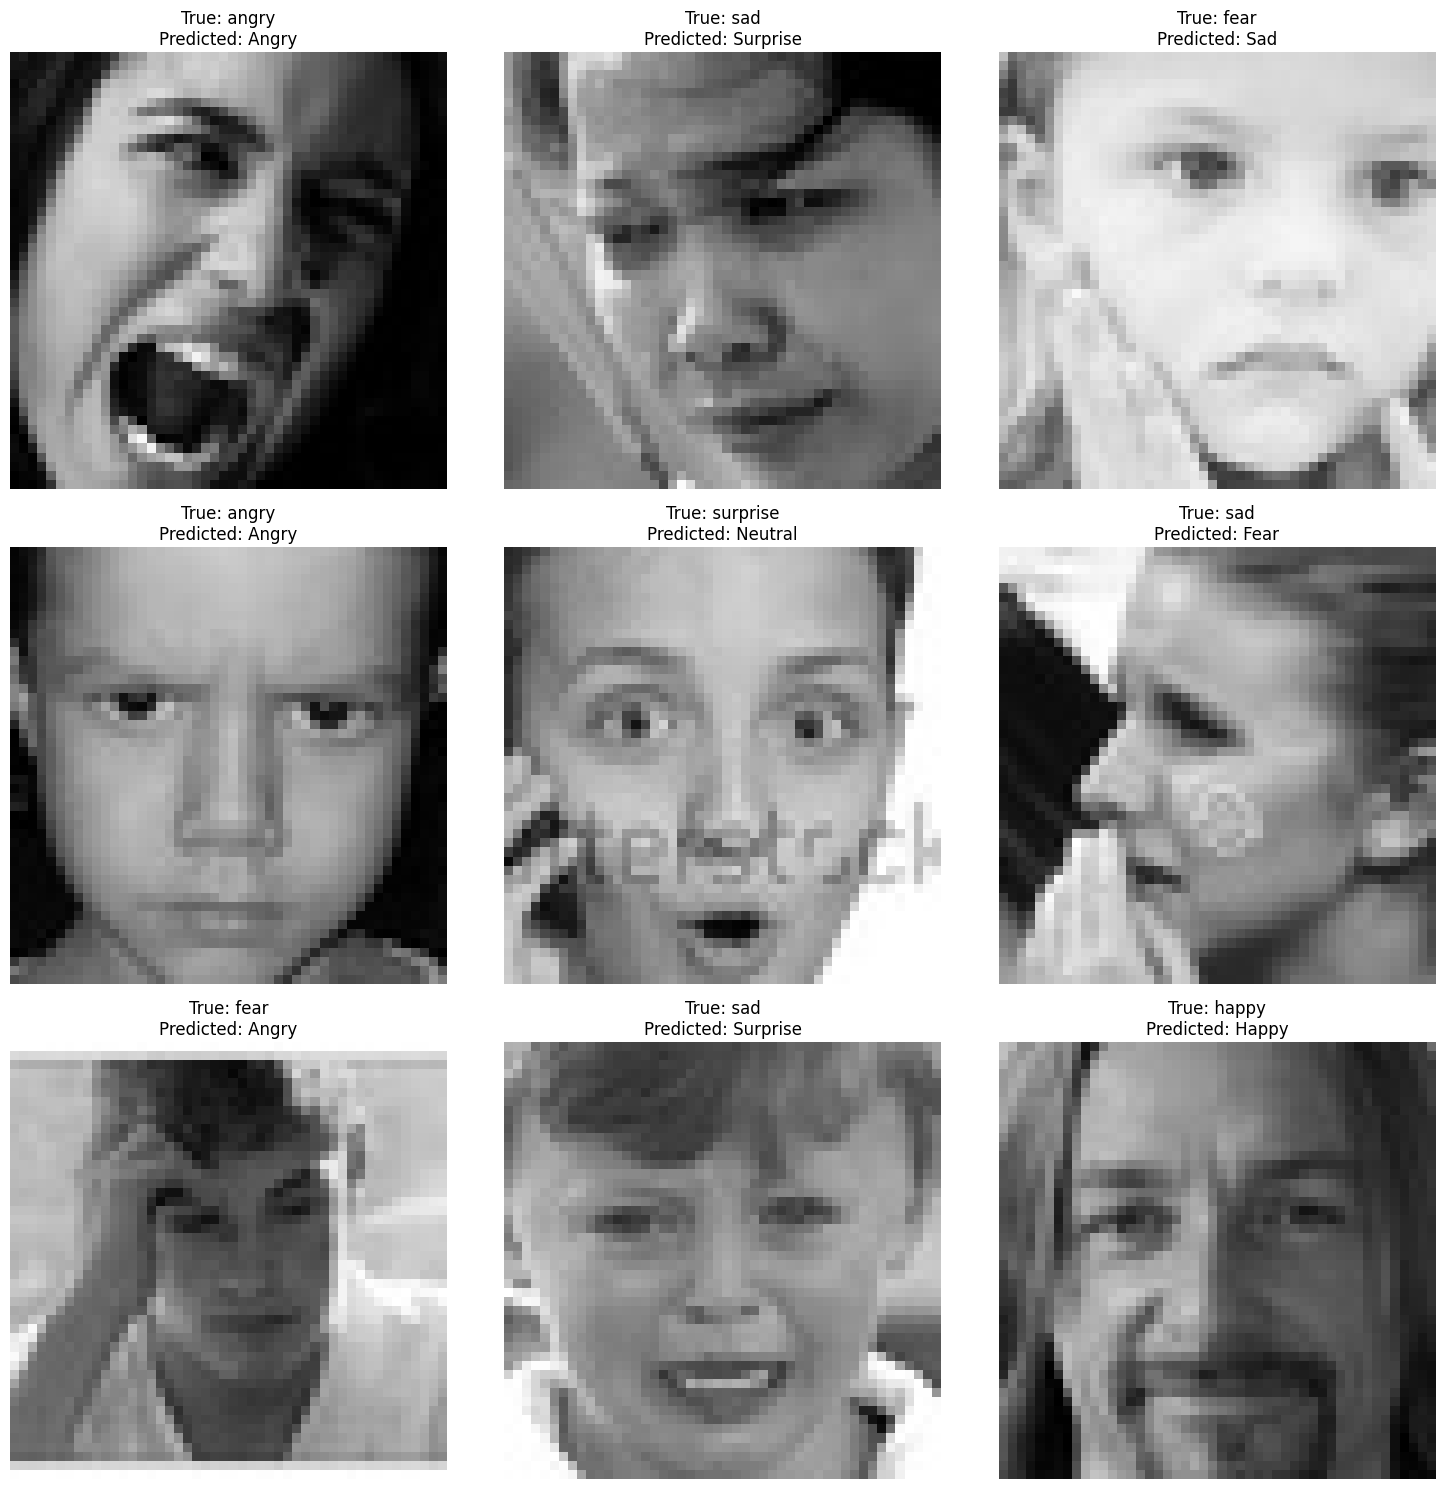

In [ ]:
# Load the trained model
model_path = '/content/drive/MyDrive/Emotion_Detection/CNN_Model/CNN_Output/CNN_model.keras'
CNN_model = load_model(model_path)

# Function to load and preprocess an image for prediction using OpenCV
def load_and_preprocess_image_cv(img_path, target_size=(48, 48)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img_array = np.expand_dims(img, axis=0)
    img_array = img_array / 255.0
    return img_array

# Function to predict emotion for a single image using OpenCV
def predict_emotion_cv(img_path, model):
    img_array = load_and_preprocess_image_cv(img_path)
    prediction = model.predict(img_array)
    predicted_label = np.argmax(prediction, axis=1)
    return predicted_label[0]

# Map of class indices to emotion labels
class_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Function to display images with predicted and true labels using OpenCV
def display_predictions_cv(images_dir, model, num_images=9):
    image_files = [os.path.join(root, file)
                   for root, _, files in os.walk(images_dir)
                   for file in files if file.endswith(('.png', '.jpg', '.jpeg'))]

    # Select a subset of images to display
    selected_images = np.random.choice(image_files, num_images, replace=False)

    # Create a plot to display the images
    plt.figure(figsize=(15, 15))

    for i, img_path in enumerate(selected_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        true_label = img_path.split(os.path.sep)[-2]

        # Predict the emotion using the CNN model
        predicted_label = predict_emotion_cv(img_path, CNN_model)
        predicted_label_name = class_labels[predicted_label]

        # Display the image
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f'True: {true_label}\nPredicted: {predicted_label_name}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example: Visualize predictions on the test images using OpenCV
test_images_dir = '/content/drive/MyDrive/fer2013/test_images'  # Path to test images
display_predictions_cv(test_images_dir, CNN_model, num_images=9)  # Display predictions for 9 random images
